In [6]:
from IPython.display import Image
import torch; torch.manual_seed(10)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([128, 1, 28, 28])


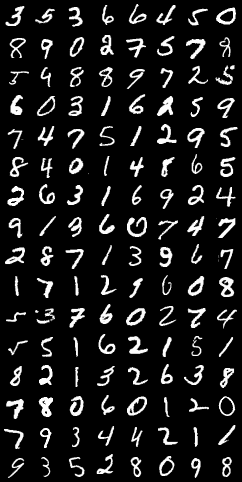

In [8]:
fixed_x, _ = next(iter(data))
save_image(fixed_x, 'real_image.png')
print(fixed_x.shape)
Image('real_image.png')

In [50]:
class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.Flatten(),
                                   )
        self.linear1 = nn.Linear(in_features=64*7*7, out_features=latent_dimension)
        self.linear2 = nn.Linear(in_features=64*7*7, out_features=latent_dimension)

    def forward(self, x):
        x = self.model(x)
        
        x_mu = self.linear1(x)
        x_logvar = self.linear2(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(in_features=latent_dimension, out_features=64*7*7)
        self.model = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
                                     nn.Sigmoid(),
                                    )

    def forward(self, z):
        hat_x = F.relu(self.linear(z))
        hat_x = hat_x.view(-1, 64, 7, 7)
        hat_x = self.model(hat_x)
        return hat_x

In [54]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        z = self.latent_sample(latent_mu, latent_logvar)
        hat_x = self.decoder(z)
        return hat_x, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
      
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [113]:
from tqdm.notebook import trange, tqdm

def vae_loss(hat_x, x, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(hat_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

def train_vae(net, data, epochs=10, learning_rate=1e-3, device=device):
    
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    criterion = vae_loss
    
    net = net.to(device)
    net = net.train()

    t = trange(1, epochs + 1, desc="model training")
    for epoch in t:
        avg_loss = 0
        
        for images, y in tqdm(data):
            images = images.to(device)

            reconstructions, latent_mu, latent_logvar = net(images)
            
            loss = criterion(reconstructions, images, latent_mu, latent_logvar)

            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(data)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net #net.to("cpu").eval()

In [94]:
vae = VariationalAutoencoder(10)
vae = train_vae(vae, data)

model training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [100]:
print(vae)

VariationalAutoencoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (linear1): Linear(in_features=3136, out_features=10, bias=True)
    (linear2): Linear(in_features=3136, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=10, out_features=3136, bias=True)
    (model): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): Sigmoid()
    )
  )
)


In [104]:
from torchsummary import summary

summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          32,832
              ReLU-4             [-1, 64, 7, 7]               0
           Flatten-5                 [-1, 3136]               0
            Linear-6                   [-1, 10]          31,370
            Linear-7                   [-1, 10]          31,370
           Encoder-8       [[-1, 10], [-1, 10]]               0
            Linear-9                 [-1, 3136]          34,496
  ConvTranspose2d-10           [-1, 32, 14, 14]          32,800
             ReLU-11           [-1, 32, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]             513
          Sigmoid-13            [-1, 1, 28, 28]               0
          Decoder-14            [-1, 1,

In [101]:
with torch.no_grad():
    noise = torch.randn(10).to(device)
    generated_images = vae.decoder(noise)
generated_images.shape

torch.Size([1, 1, 28, 28])

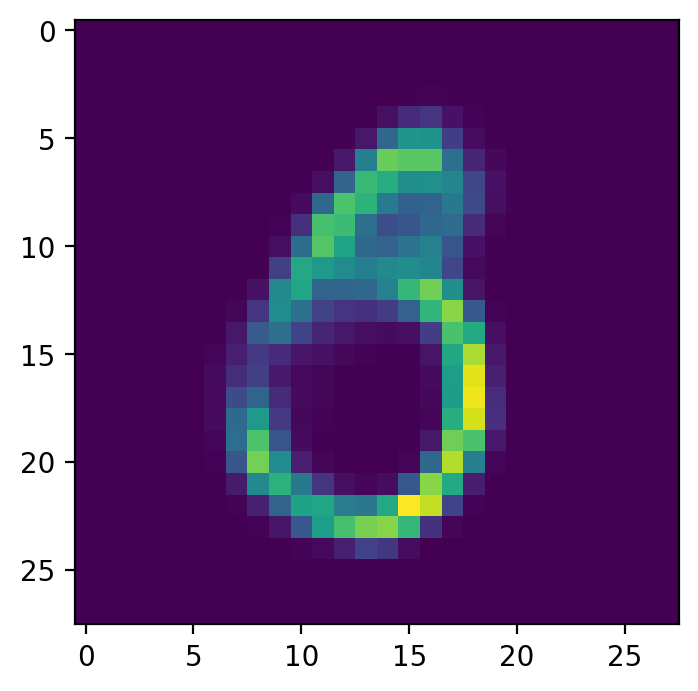

In [102]:
plt.imshow(generated_images.cpu().detach().numpy().reshape(28,28))